<a href="https://www.nvidia.com/dli/"> <img src="https://developer.download.nvidia.com/training/images/DLI%20Header.png" alt="Header" style="width: 400px;"/> </a>

# Introduction
Natural Language Processing (NLP) is a set of techniques and algorithms that use computers for analyzing natural human language.  NLP can be used to solve a variety of problems, for example:

* Subject Matter Identification - What are the topics, people, companies or places discussed in this text?
* Sentiment Analysis - Does this text convey a positive, negative or neutral feeling about an entity or subject matter?
* Machine Translation - Convert the input from one language to another, for example, from English to French
* Text-to-Speech - Convert the spoken input into its written form
* Understanding and Interpretation - What information will answer a specific question?

Early NLP systems used rules manually designed by domain experts.  As the field advanced, the use of machine learning enabled the application of more powerful models that took advantage of ever-growing amounts of data.  Today we are taking advantage of Deep Learning and the immense computational power of GPUs to tackle ever more complex NLP tasks.

In this lab we will focus on the following:
1. The bag-of-words representation and its shortcomings
2. Computing word embeddings using the Word2Vec algorithm
3. Applying pre-trained word embeddings to a text classification problem




# The Importance of Data Representation in NLP

One of the most important issues that data scientists encounter is how to represent their data to an algorithm.  This is especially relevant in NLP where inputs often differ in lengths, taking the form of sentences or even entire documents. Regardless of input length it is important to develop a representation that can capture similar themes and/or uses of domain-specific terms and vocabulary. We will demonstrate this using examples from Brian Wildsmith's wonderful children's book 'Cat on the Mat'.

### Bag-of-Words Representation
A common way of representing text is using the Bag-of-Words (BoW) approach, where we simply count the number of occurrences of each word in our *corpus*, a collection of individual texts or *documents*, for each individual item in the collection: 

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import HTML

corpus = pd.read_csv("D:/Documents/PPCC/COM225/Week 4/Dream.txt")

vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=False)
representation = vectorizer.fit_transform(corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
representation_df

,sentiment
0,1


For this representation we count how often a word appears in a given input. This count is typically referred to as a *term frequency*. The collection of all unique words for a corpus is referred to as the *vocabulary* for the corpus. In the Bag-of-Words representation, the size of the vocabulary plays a significant factor in the size of the representation of the text.



A similar representation uses a binary value for each word as opposed to a discrete count. This is often referred to as a one-hot encoding. It has the advantage of being relatively compact because each word in a vocabulary is represented using a single bit. This representation is frequently used when term frequency is irrelevant to the application at hand.

We use the *CountVectorizer* object from Python's Scikit-Learn package of Machine Learning tools and algorithms.  See the API for CountVectorizer [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

**Exercise**: Use the CountVectorizer object to create a binary value for each word.  See [here](#hint1 "Use the binary= argument to the constructor") if you need a hint.

In [2]:
vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=True) ##TODO## : Use CountVectorizer to create a binary value for each word
representation = vectorizer.fit_transform(corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
representation_df

,sentiment
0,1


In many cases it is often beneficial to drop *stop words*, such as *the*, *on*, *in* and similar, because they appear frequently, do not add meaning to the text and otherwise require resources to represent. Stop words differ between languages and lists for some languages are available from [https://www.ranks.nl/stopwords](https://www.ranks.nl/stopwords). Dropping stopwords can reduce vocabulary size and thus the overall size of a representation.

**Exercise**:  Use the CountVectorizer object to remove English stop words.  See [here](#hint2 "Use the stop_words= argument to the constructor") for a hint.

In [3]:
vectorizer = CountVectorizer(lowercase=True, stop_words='english', binary=False)##TODO## : Use CountVectorizer to remove English stopwords
representation = vectorizer.fit_transform(corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
representation_df

,sentiment
0,1


There are other ways to represent word counts such as [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) that takes into account how often a word appears in document in comparison to how often the word appears in a given corpus. This gives some weight to words that appear less frequently and de-emphasises common, more frequent words.

#### Issues with the Bag-of-Words Representation

BoW is a good way to represent textural data and has been effectively used for regularly achieving 70-80 percent accuracy on various NLP tasks quickly and efficiently.  However, it suffers from three primary shortcomings:
1.  Invariance to word order
2.  Lack of semantic generalization
3.  The representations are large, yet sparsely populated

We will investigate each in turn.

##### Invariance to Word Order
In the above examples, notice that the BoW representation is unable to capture the original order in which the words appeared in the corpus.  To explore this concept further, consider the representation of sentences that use the same words but differ only in their ordering:


In [4]:
ordering_corpus = pd.read_csv("D:/Documents/PPCC/COM225/Week 4/Dream.txt", encoding="ISO-8859-1")
ordering_vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=True, stop_words='english')
representation = ordering_vectorizer.fit_transform(ordering_corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(ordering_vectorizer.vocabulary_.keys()))
representation_df

,sentiment
0,1


Note that the representations are all identical.  In particular, note that the second sentence - unless used in a comical or cynical context - makes no sense and the third is not even grammatically correct in English.  While word order invariant representations are often sufficient for simple tasks, the inclusion of word order is required for achieving higher accuracy in many cases.

##### Lack of Semantic Generalization
Looking at original corpus of sentences above, it is clear that we can formulate them in the following manner:

*The X sat on the mat*

where *X* is an animal:  cat, dog or goat.  How are these represented in BoW?

In [5]:
vectorizer.vocabulary_

{'sentiment': 0}

So *cat* is the first feature (will appear in position 0 of a 1-hot encoded vector), *dog* is the second (position 1 of the vector) and so on.  It appears that in this case features are sorted by alphabetical order.  We can check by adding another animal, one that appears before *cat*:

In [8]:
feature_corpus = ['The cat sat on the mat', 'The dog sat on the mat', 'The bird sat on the mat']
feature_vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=True, stop_words='english')
representation = feature_vectorizer.fit_transform(feature_corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(feature_vectorizer.vocabulary_.keys()))
representation_df

,bird,cat,dog,mat,sat
0,0,1,0,1,1
1,0,0,1,1,1
2,1,0,0,1,1


Now *bird* is the first feature, *cat* is the second and *dog* is the third.  

In the book, we have multiple animals that sit on the mat (cat, dog, goat, elephant).  This implies that only animals are able to sit on the mat while other objects are not.  Let's now attempt to build a simple classification model for deciding whether *X on the mat* is an allowed state-of-affairs or not - in other words, a text classification problem.

Note:  after running the cell below, please make sure that you do not change the contents of the *vectorizer* variable.

In [12]:
training_corpus = ['The cat sat on the mat', 'The dog sat on the mat', 'The goat sat on the mat', 'The elephant sat on the mat', 
          'The plane sat on the mat', 'The apple sat on the mat', 'The pen sat on the mat', 'The notebook sat on the mat']

allowed = [1,1,1,1,   # Objects that are allowed on the mat
           0,0,0,0]   # Objects that are not allowed on the mat

# Make sure that words we'll use in the test set are considered
for other_object in ['keyboard', 'bird']:
    training_corpus.append(other_object)   
    
vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=True, stop_words='english')
representation = vectorizer.fit_transform(training_corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
representation_df

,apple,bird,cat,dog,elephant,goat,keyboard,mat,notebook,pen,plane,sat
0,0,0,1,0,0,0,0,1,0,0,0,1
1,0,0,0,1,0,0,0,1,0,0,0,1
2,0,0,0,0,0,1,0,1,0,0,0,1
3,0,0,0,0,1,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,1,1
5,1,0,0,0,0,0,0,1,0,0,0,1
6,0,0,0,0,0,0,0,1,0,1,0,1
7,0,0,0,0,0,0,0,1,1,0,0,1
8,0,0,0,0,0,0,1,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logistic = LogisticRegression()
y = allowed
X = representation_df[:len(y)]

logistic.fit(X,y) # Only train on the first 8 sentences
print("Training accuracy score is:  {} %".format(accuracy_score(logistic.predict(X), y)*100.0))

Training accuracy score is:  100.0 %


We see that a simple [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model is able to learn our training data perfectly - animals are allowed on the mat, other objects are not.  Let's now see whether our model is able to *generalize* to other animals and objects:

**Exercise**:  Transform the sentences in the test corpus into a BoW representation.  See [here](#hint3 "X_test = vectorizer.transform(test_corpus)") for the answer.

In [14]:
test_corpus = ['The keyboard sat on the mat', 'The bird sat on the mat']
X_test = vectorizer.transform(test_corpus)##TODO## : Generate the BoW representation for the test corpus
y_test = [0,1]
print("Expected Results for (keyboard, bird):  {}".format(y_test))
print("Actual   Results for (keyboard, bird):  {}".format(logistic.predict(X_test)))


Expected Results for (keyboard, bird):  [0, 1]
Actual   Results for (keyboard, bird):  [0 0]


We see that this simple model was unable to capture the generalization that animals are allowed on the mat.  Perhaps a more powerful model would have been able to do this.  However, we would ideally like the notion of *animal* - a semantic concept - to be captured directly in the input representation if possible.  In other words, we'd like a representation that is 'smarter' in itself, regardless of the algorithm used.

##### Sparseness
In the BoW representation, every word is a feature.  So for large corpora, this means that a 1-hot encoded vector for a single sentence can be very long.  For example, in a vocabulary with 1000 words and 10 words per sentence, a single input vector will be 1000 x 10 
= 10000 parameters.  A large corpus can easily contain many more words, and sentences can easily be 30 or 40 words long. The problem of large vocabularies and the computational complexity they bring is sometimes referred to as 'the curse of dimensionality'

In addition, a single sentence normally contains only a small fraction of all possible words in the vocabulary.  This means that most values in our input will have the value 0. This is known as a sparse representation because the representation is only sparsely populated with data.  The result is that we have many parameters which in turn will require the use of a large amount of data for training a model or risk overfitting.  It is possible to use only the top *k* words from a vocabulary (as the [distribution of words in natural language](https://en.wikipedia.org/wiki/Zipf's_law) tends to have a small number of very frequent words), but this is only a stopgap measure and does not directly address the problem.

# Distributed Representations, aka Word Embeddings


Now that we have seen some of the issues that affect the BoW representation, how can Deep Learning help?  In this section we discuss how to create better representations using techniques based on neural networks.  

### Some Help from Theoretical Linguistics

In order to get a good intuition for word embeddings, it is helpful to look at the [Distributional Hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics#Distributional_hypothesis) which was first formulated in the context of Linguistics, specifically, statistical semantics:

> A word is characterized by the company it keeps 

> (Firth, 1957)

In simple terms, the Distributional Hypothesis states that words that appear in similar *syntactic* contexts tend to have similar *semantic* meanings.  Stated differently:  words have similar meanings when the words that precede and/or follow them are the same.  Using our examples from above and designating the animal in each sentence as X:

The *cat* sat on the mat

The *dog* sat on the mat

The *elephant* sat on the mat

In all of those examples X is preceded by the word 'The' and followed by the words 'sat on'. More specifically, X is preceded by the sequence '`<PAD>` The', where `<PAD>` signifies a padding value used to indicate the beginning or ending of a sentence. This is known as a *context* of 2 words, with two 'words' captured on either side of the target word.  Indeed by definition all of these X's have something in common - they are animals.  Let's compare those examples to the following:

The *quickly* sat on the mat

Obviously, with the sentence being non-grammatical, the word *quickly* does not appear in the same context as our animals.  
How about a valid sentence?

The *monitor* sat on the mat

While a noun in the position of X is grammatical, it does not make semantic sense and would probably not be used in regular, everyday speech.  By applying the Distributional Hypothesis we can now assume that *quickly* and *monitor* are not semantically similar to animals based on the text that we have available.



### Computing Word Embeddings

From a mathematical viewpoint, embeddings are a [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) technique.  In the BoW representation, every unique word is a single dimension, and there are $|V|$ dimensions altogether (where $V$ is the set of all words in the corpus).  Embeddings, on the other hand, are lower-dimensional, usually between 50 and 300 dimensions. Embeddings are also dense vectors, typically possessing a value for each of the dimensions present.  Each dimension is essentially a *latent factor* that encodes some information about that particular word.  Therefore, embeddings are also known as *distributed representations*.    

Embeddings possess a particularly interesting property:  when trained on a large corpus, those latent factors tend to encode semantics from the corpus' domain!  In other words, the model learns concepts and ideas that are specific to that domain.  Probably the most well-known example is from Mikolov et al's 2013 influential [paper](https://arxiv.org/pdf/1301.3781.pdf)):

*vector('king') - vector('man') + vector('woman') ~= vector('queen')*

That is, when subtracting the embedding of 'man' from the embedding of 'king' and following that with the addition of the embedding of 'woman' (keeping in mind that embeddings are just vectors), the closest embedding to the result is the one for the word 'queen'.  Other examples are given in the paper from Mikolov.

The paper just discussed introduces Word2Vec - an algorithm for computing word embeddings.  In this lab, we will compute word embeddings for a small corpus using this algorithm.  Specifically, we will use the *skip-gram* variant of the algorithm (the paper also describes a variant called *Continuous Bag-of-Words* or *CBOW* - see below). 


### Word2Vec  Skip-gram

![](images/skip-gram.png)
*Skip-gram architecture, source: Mikolov et al.*


The skipgram algorithm functions by selecting pairs of target and context words and training a model to recognize whether the context word appears in the context window of the target.  For example, given the sentence *the cat sat on the mat*, the target word *sat* and a context window size of 1, the (target, context) pairs will be:
* (sat, cat)
* (sat, on)

For a context window of size 2, an additional pair will be added: 
* (sat, the)  (note that 'the' appears both 2 words before and after 'sat')

We begin by creating a model with two inputs, namely the target and context words.  Next, we add an *embedding layer*.  This layer is a matrix of size $|V|\times d$, with $V$ as defined above and $d$ as the dimension of the embedding (which is a hyper-parameter).  Essentially, the embedding layer serves as a lookup table, where the (1-hot encoded) target and context words each select a single row (i.e., vector) from the matrix.  This row is the embedding, and it is up to our algorithm to learn it.

The next step is to compute a similarity score between the two vectors using the dot product operator.  As explained above, words that are in similar contexts tend to have semantic similarities - hence we would like our model to learn that each (target, context) pair should have a high similarity score.  

Finally, we use a technique called *negative sampling*.  In negative sampling, not only do we choose (target, context) pairs from a given sentence - we also choose pairs that *do not* appear in the sentence - i.e., (target,not(context)).  For these pairs, we would like the similarity score to be low.  An example for the same sentence:

* (cat, sat) - Positive sample
* (cat, dog) - Negative sample

As such, our input dataset consists of (target, context) pairs and a labels which are either 0 or 1, depending on whether this pair is a positive or negative sample.  Note that while we have labels, this is actually an *unsupervised* problem, as we generate the labels directly from the text.  Therefore, it is possible to run this algorithm on large amounts of text without human involvement.  The algorithm will then produce embeddings that are specific to that corpus.

For this lab, we will extend our corpus by adding more animals, as well as adding further actions and even nouns that denote furniture.  Recall that words for each category are semantically similar, as they appear in the same contexts.

In [15]:
import itertools

animals = ['cat','dog','goat','elephant','eagle','zebra','rhino', 'hippo']
actions = ['sat','stood','jumped','slept']
furniture = ['mat','rug','sofa','bed']

# Generate all combinations of animal, action and furniture
animal_corpus = ['The {} {} on the {}'.format(x[0], x[1], x[2]) for x in itertools.product(animals, actions, furniture)]
vocabulary_size = len(animals) + len(actions) + len(furniture) + 2

print("There are {} sentences in the corpus, with a vocabulary of {} words".format(len(animal_corpus), vocabulary_size))

There are 128 sentences in the corpus, with a vocabulary of 18 words


Once we have a corpus, we use the Keras library (with a Tensorflow backend) for preprocessing and model construction.  The initial step is to convert each sentence into a sequence of numbers, where each word has a unique index to be used in a 1-hot encoding.  While this construction is very similar to what happens in Bag-of-Words, the representation will only be used to train the embeddings and *not* for any additional, downstream NLP tasks. 

The *Tokenizer* object breaks sentences into words, lower-cases them and gets rid of any special characters such as punctuation.  It then assigns each word a unique index (as we just described).  The *skipgram* function then creates the (target, context) pairs.  We configure it to use negative sampling and have use a hyper-parameter for the context window size.  Interestingly, note that we do not drop stopwords here.

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
import numpy as np

# Hyper-parameters

EMBEDDING_SIZE = 7  # Small corpus, so we're using a small dimension
WINDOW_SIZE = 4     # Empirically found to work well

# Convert text to numerical sequences

# Note that the Tokenizer starts numbering words with 1.  So we have vocabulary_size+1 words.  The 0-th word
# is considered to be the 'Out-of-vocabulary' token.
tokenizer = Tokenizer(num_words=vocabulary_size+1, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~ ', lower=True, split=' ',)
tokenizer.fit_on_texts(animal_corpus)
sequences = tokenizer.texts_to_sequences(animal_corpus)

# Generate (target, context) pairs with negative sampling

pairs = []
labels = []

for this_sequence in sequences:
    # Again note the vocabulary_size+1 expression
    c, l = skipgrams(this_sequence, vocabulary_size+1, window_size=WINDOW_SIZE, negative_samples=1, shuffle=True)
    for i in range(len(c)):
        pairs.append(c[i])
        labels.append(l[i])
pairs = np.array(pairs)
labels = np.array(labels)
    
print("There are {} (context,target) pairs in the dataset".format(len(pairs)))

Using TensorFlow backend.


There are 7168 (context,target) pairs in the dataset


We now build and train the model.

**Exercise**: Add the Embedding layer in the code below.  See [here](#hint4 "Embedding(vocabulary_size+1, EMBEDDING_SIZE, input_length=1, name='embedding_layer') for the answer.

**Exercise**:  Add the Dot Product layer in the code below.  See [here](#hint5 "Dot(axes=1)([target_embedding, context_embedding])") for the answer.

In [17]:
from keras.layers import Embedding, Input, Dense, Reshape
from keras.layers.merge import Dot
from keras.models import Model
from keras.optimizers import RMSprop



target_word = Input((1,))
context_word = Input((1,))

# An embedding layer is just a lookup table - a matrix of size vocabulary_size x EMBEDDING_SIZE
# We select input_length rows from this matrix

embedding_layer = Embedding(vocabulary_size+1, EMBEDDING_SIZE, input_length=1, name='embedding_layer')##TODO## :  Add embedding layer nambed 'embedding_layer'.  Remember to add 1 to the vocabulary size!

# Expect an output of similarity score between 0 and 1
output_layer = Dense(1, activation='sigmoid')

# Select the row indexed by target_word, reshape it for convenience
target_embedding = embedding_layer(target_word)
target_embedding = Reshape((EMBEDDING_SIZE,))(target_embedding)

# Select the row indexed by context_word, reshape it for convenience
context_embedding = embedding_layer(context_word)
context_embedding = Reshape((EMBEDDING_SIZE,))(context_embedding)


# Perform the dot product on the two embeddings, and run through the output sigmoid 
output = Dot(axes=1)([target_embedding,context_embedding])##TODO## : Add dot product layer

output = output_layer(output)
    
# Setup a model for training
model = Model(inputs=[target_word, context_word], outputs=output)

optimizer = RMSprop(lr=0.0001, rho=0.99)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 1, 7)         133         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 7)            0           embedding_layer[0][0]            
__________

In [18]:
# Only print the results after this many epochs
INTERNAL_EPOCHS = 100

TOTAL_EPOCHS = 1500

def train(X,y):
    for index in range(int(TOTAL_EPOCHS / INTERNAL_EPOCHS)):
        h = model.fit(x=X, y=y, batch_size=256, epochs=INTERNAL_EPOCHS, verbose=0)
        print('Epoch {} - loss {}'.format((index + 1) * INTERNAL_EPOCHS, h.history['loss'][-1]))

train([pairs[:,0], pairs[:,1]], labels)        


Epoch 100 - loss 0.6739963016339711
Epoch 200 - loss 0.6529679128101894
Epoch 300 - loss 0.6483458152839116
Epoch 400 - loss 0.6459175816604069
Epoch 500 - loss 0.6443299310547965
Epoch 600 - loss 0.6432460780654635
Epoch 700 - loss 0.6424462816544941
Epoch 800 - loss 0.641840113060815
Epoch 900 - loss 0.6413463694708688
Epoch 1000 - loss 0.640941417643002
Epoch 1100 - loss 0.6405968176467078
Epoch 1200 - loss 0.6402933065380368
Epoch 1300 - loss 0.6400272122451237
Epoch 1400 - loss 0.6397905392306191
Epoch 1500 - loss 0.6395729269300189


We discussed the fact that embeddings capture the semantics inherent in the corpus.  Hence, it would be interesting to look 'inside' our results.  We'll try a dimensionality-reduction operation so that we can plot the learned representations on a 2-D plane (our computer screen).  One possible technique is [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).  We use the PCA functionality in Python's [Scikit-Learn](http://scikit-learn.org/stable/index.html) library, and color the embeddings based on their categories.  'Good' embeddings will show up as well-defined clusters - individual words will be closer to words of the same category than to words of other categories.  Try running the previous cell multiple times and observe the results.

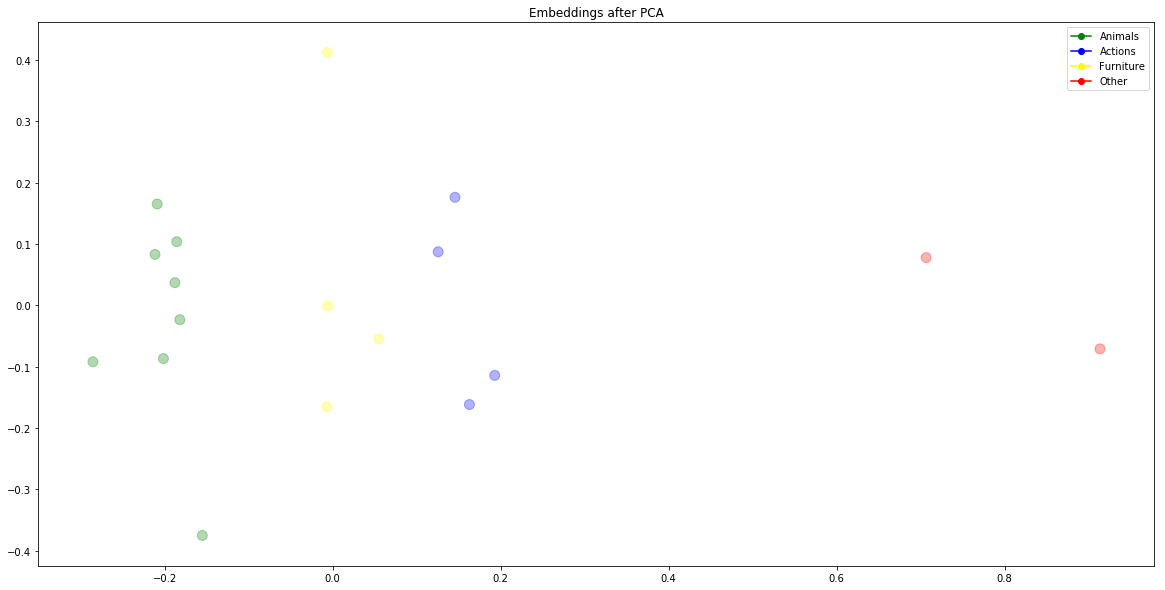

In [19]:
%matplotlib inline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


category_colors = {'animals' : 'green', 
                   'actions' : 'blue',
                   'furniture' : 'yellow'}

colors = []
for i in range(vocabulary_size):
    colors.append('red')
    
for word in tokenizer.word_index:
    index = tokenizer.word_index[word] -1
    if word in animals:
        colors[index] = category_colors['animals']
    elif word in actions:
        colors[index] = category_colors['actions']
    elif word in furniture:
        colors[index] = category_colors['furniture']
        
def plot_embeddings_after_pca(vectors):  
        """
        Perform PCA and plot the resulting 2 components on X and Y axis
        Args:
          embedding_weights - the set of vectors to 
        """
        pca = PCA(n_components=2)
        vectors_pca = pca.fit_transform(vectors)
        plt.figure(figsize=(20,10))
        
        # We do not draw the first element, which is the 'Out-of-Vocabulary' token
        plt.scatter(vectors_pca[1:,0], vectors_pca[1:,1], c=colors, s=100, alpha=0.3);
        plt.title('Embeddings after PCA')
        legend_elements = [
                    plt.Line2D([0], [0], marker='o', color=category_colors['animals'], label='Animals'),
                    plt.Line2D([0], [0], marker='o', color=category_colors['actions'], label='Actions'),
                    plt.Line2D([0], [0], marker='o', color=category_colors['furniture'], label='Furniture'),
                    plt.Line2D([0], [0], marker='o', color='red', label='Other'),
                  ]

        # Create the figure
        plt.legend(handles=legend_elements);

        
plot_embeddings_after_pca(model.get_layer('embedding_layer').get_weights()[0])






#### Exercise
1.  Experiment with embedding and context window sizes to get some intuition for how they affect the final results.
2.  Try replacing the dot product operation with other ways of combining two vectors. Look at the [keras.layers.merge](https://keras.io/layers/merge/) package for inspiration.  How do these affect the embedding quality?
3.  How does the choice of epochs and/or optimizer affect the embedding quality? Try another optimizer from the [keras.optimizers](https://keras.io/optimizers/) package.

### Code Exercise - Implementing CBoW

In the previous section, we experimented with the *skip-gram* version of Word2Vec.  As mentioned, there is also a different variant named *Continuous Bag-of-Words (CBoW)*.  Recall that the Bag-of-Words representation does not take word order into account.  The CBoW approach is similar - but generates distributed representations in contrast to the discrete and sparse representation generated by BoW.

In this section, you will implement the CBoW approach from Word2Vec.

#### CBoW Approach

![](images/CBOW.png)
*CBoW architecture, slightly modified from Mikolov et al.*

In contrast to skip-grams, CBoW considers all words on each side of the target word simultaneously.  In the figure above, $w(t-1)$ and $w(t-2)$ are the embeddings of the context words that appear to the left of the target word while $w(t+1)$ and $w(t+2)$ are those content words that appear to the right.  In this case, the window size is 2, and in total there are 4 context words.  Once the context words are identified, the next stage is taking the *mean* of the context embeddings.  In truth, any operation that merges the context embeddings could work, such as $sum$. At this point, word order is lost and this is where the Bag-of-Words name derives from. From there on, it is a simple matter of attaching a [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation for selecting the 1-hot encoded context word (denoted $w(t)$).

The following cell contains the code to generate sequences of length *window_size*, along with the 1-hot encoded representation of the context word.

In [20]:
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.layers import Lambda
import keras.backend as K

window_size = 2

def make_cbow_data(sequences, window_size):
    """
    Prepare CBOW data - given a sequence of words, return the set of subsequences of window_size words on the left and the right
    along with the 1-hot encoded context word
    Args:
      sequences - set of sequences that encode sentences
      window_size - the amount of words to look to the left and right of the context word
    Returns:
      num_classes - number of words in vocabulary
      X - numpy array of window_size words to the left and right of the context word
      y - 1-hot encoding of the context word
    """
    X = []
    y = []
    num_classes = len(np.unique(np.hstack(sequences)))+1
    for this_sequence in sequences:
        for output_index, this_word in enumerate(this_sequence):
            this_input = []
            y.append(np_utils.to_categorical(this_word, num_classes))
            input_indices = [output_index - i for i in range(window_size,0,-1)]
            input_indices += [output_index + i for i in range(1, window_size+1)]
            for i in input_indices:
                this_input.append(this_sequence[i] if i >= 0 and i < len(this_sequence) else 0)
            X.append(this_input)
    return num_classes, np.array(X),np.array(y)
                
   
        
num_classes, cbow_X, cbow_y = make_cbow_data(sequences, window_size)
print("cbow_X shape: {}".format(cbow_X.shape))
print("cbow_y shape: {}".format(cbow_y.shape))

cbow_X shape: (768, 4)
cbow_y shape: (768, 19)


In this cell, complete the code that implements the model.  See [here](#hint6 "Use the Embedding, Lambda and Dense layers available in Keras.  For the mean operation, use the K object which allows access to the Keras backend.") for a hint. A solution is available at the end of this notebook.

Some hints for completing the exercise:
* Use the Keras *Lambda* layer (documentation [here](https://keras.io/layers/core/#lambda)) to wrap the use of the K.mean function in the mean_layer code
* Use a *softmax* activation for the output layer

In [26]:
inputs = Input((window_size * 2,))

embedding_layer = Embedding(num_classes, EMBEDDING_SIZE, input_length=2*window_size, name='embedding_layer')
mean_layer = Lambda(lambda x: K.mean(x, axis=1))
output_layer = Dense(num_classes, activation='softmax')

output = embedding_layer(inputs)
output = mean_layer(output)
output = output_layer(output)

model = Model(inputs=[inputs], outputs=output)

optimizer = RMSprop(lr=0.1, rho=0.99)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)



You can now train the model, and compare the embeddings generated by CBoW to those of skipgram above.

In [27]:
train(cbow_X, cbow_y)

Epoch 100 - loss 0.8286786079406738
Epoch 200 - loss 0.8240158359209696
Epoch 300 - loss 0.8243815700213114
Epoch 400 - loss 0.8299251794815063
Epoch 500 - loss 0.8248688578605652
Epoch 600 - loss 0.8191262682278951
Epoch 700 - loss 0.8296817739804586
Epoch 800 - loss 0.8169069488843282
Epoch 900 - loss 0.8157468438148499
Epoch 1000 - loss 0.8192495107650757
Epoch 1100 - loss 0.8211601972579956
Epoch 1200 - loss 0.8191891511281332
Epoch 1300 - loss 0.8183315793673197
Epoch 1400 - loss 0.8207951784133911
Epoch 1500 - loss 0.8172112504641215


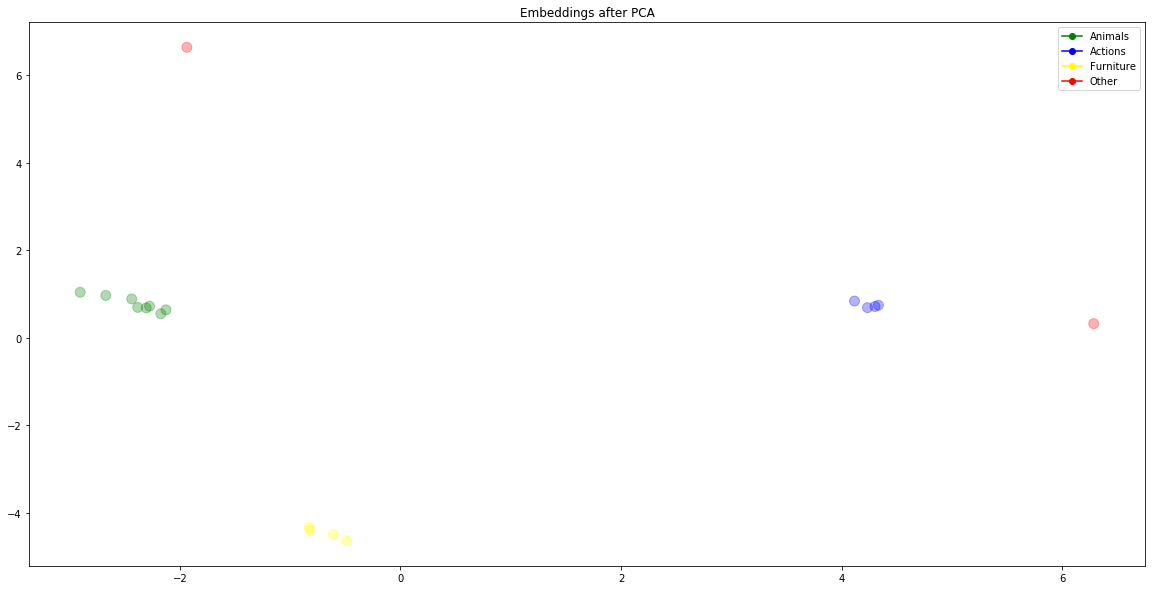

In [28]:
plot_embeddings_after_pca(model.get_layer('embedding_layer').get_weights()[0])

### Applying Word Embeddings

In the next section, we'll see how to apply word embeddings that have been pre-trained.  We'll use embeddings generated using the *FastText* algorithm that was developed by Facebook AI.  It is similar to Word2Vec that we saw above in that it has both CBOW and Skipgram variants, but it performs the actual 'construction' of the embedding in a different way (and was specifically designed for languages that have complex [morphology](https://en.wikipedia.org/wiki/Morphology_(linguistics)).  Facebook has already trained embeddings on a large corpus (in this case, Wikipedia dumps for multiple languages) and makes this data available [on the Facebook Research GitHub site](https://github.com/facebookresearch/fastText/blob/bc1285939f1c216bd358425c3685a049dd8f56c0/docs/crawl-vectors.md).  This link also contains a reference to the paper describing the FastText algorithm.  

We will repeat the small experiment we performed at the beginning of the lab, but this time we will use FastText word embeddings.  Will our classifier be able to generalize?

In [29]:
from gensim.models import KeyedVectors

# Load embeddings from the pre-trained file
fastText_embeddings = KeyedVectors.load_word2vec_format('/dli/data/wiki/wiki.simple.vec')

In [30]:
def build_data_set(corpus):
    """
    Iterate over all sentences in the corpus and for each word, copy the embedding to the appropriate indices
    Args:
      corpus - list of individual sentences in the corpus
    Returns:
      X - Matrix of 1-hot encodings of the sentences
    """
    
    # Assume all sentences are of equal length - otherwise we'll need to truncate or pad
    words_in_sentence = len(corpus[0].split(' '))
    
    # Initialize 
    X = np.zeros((len(corpus), words_in_sentence * fastText_embeddings.vector_size))

    for sent_index in range(len(corpus)):
        words = corpus[sent_index].split(' ')
        for word_index in range(len(words)):
            start_index = fastText_embeddings.vector_size * word_index
            end_index = fastText_embeddings.vector_size * (word_index + 1)
            X[sent_index, start_index:end_index] = fastText_embeddings[words[word_index].lower()] 
    
    return X
            

# Train the model - animals are allowed on the mat, other objects are not
training_corpus = ['The cat sat on the mat', 'The dog sat on the mat', 'The goat sat on the mat', 'The elephant sat on the mat', 
          'The plane sat on the mat', 'The apple sat on the mat', 'The pen sat on the mat', 'The notebook sat on the mat']
allowed = np.array(
           [1,1,1,1,
            0,0,0,0])

X_train = build_data_set(training_corpus)
        
# Will the network be able to generalize?        
test_corpus = ['The keyboard sat on the mat', 'The bird sat on the mat']
X_test = build_data_set(test_corpus)



In [31]:
logistic_embeddings = LogisticRegression()
logistic_embeddings.fit(X_train, allowed)

y_test = [0,1]

print("Expected Results for (keyboard, bird):  {}".format(y_test))
print("Actual   Results for (keyboard, bird):  {}".format(logistic_embeddings.predict(X_test)))

Expected Results for (keyboard, bird):  [0, 1]
Actual   Results for (keyboard, bird):  [0 1]


### Summary

In this lab, we discussed the use of word embeddings as a way to represent individual words to NLP algorithms.  We went over the issues that affect the Bag-of-Words representation, and saw how word embeddings can solve them.  We then used a small corpus to train our own embeddings, and finally used a pre-trained set of embeddings for solving a text classification problem.

The concept of embeddings and distributed representations is very broad, and it will probably not surprise you to learn that there are techniques and algorithms for computing embeddings for sentences and even entire documents.  In fact, this is a one of the most active areas in NLP research.  These embeddings are able to capture semantic similarities in a domain, and so are ideal as the inputs for other, downstream NLP tasks.  

Finally, here are some best practices for training your own embeddings:
* Use a large corpus of domain-specific texts.  Using a general corpus (like Wikipedia) may affect your model's accuracy and performance for your specific application.  If you do not have a large amount of domain-specific texts, the use of *transfer learning* on pretrained embeddings may help.
* Plan for a training process that will take a long time.  The use of a GPU (or multiple GPUs) is highly recommended.
* You will need to tune both embedding dimensionality and context window size. The choices you make here will directly affect the accuracy of your model and the time required to train it.

#### [Solution for CBoW code exercise](task1_Answers.ipynb)

<a href="https://www.nvidia.com/dli/"> <img src="https://developer.download.nvidia.com/training/images/DLI%20Header.png" alt="Header" style="width: 400px;"/> </a>